In [1]:
import pandas as pd
import numpy as np
import sqlite3
import scrapbook as sb

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter
from pandas.plotting import scatter_matrix

plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]

%matplotlib inline

D:\anaconda3\envs\mfe-preprogram\lib\site-packages\papermill\iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
token = 'BTC'
from_date = '2021-11-05'
to_date = '2021-11-11'
connection_string = 'sqlite:///../../../Lectures/Lecture 4/data/data.db'


In [3]:
# Parameters
from_date = "2021-11-29 00:00:00"
to_date = "2021-12-06 00:00:00"
token = "BTC"
connection_string = "sqlite:///../../../Lectures/Lecture 4/data/data.db"


In [4]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string)
prices['ts'] = pd.to_datetime(prices['ts'])

prices.set_index('ts', inplace=True)

prices

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-11-29 00:00:00,56075.51,57490.00,56075.51,57317.17,993.419376,5.675379e+07,BTC,BTC
2021-11-29 01:00:00,57318.51,58003.80,57183.06,57809.41,1140.750133,6.567139e+07,BTC,BTC
2021-11-29 02:00:00,57809.40,58280.36,57570.02,57690.56,911.058672,5.268191e+07,BTC,BTC
2021-11-29 03:00:00,57690.57,57764.76,57338.09,57359.92,592.329247,3.410836e+07,BTC,BTC
2021-11-29 04:00:00,57360.32,57472.34,57243.53,57408.85,412.284052,2.365137e+07,BTC,BTC
...,...,...,...,...,...,...,...,...
2021-12-05 19:00:00,49351.61,49425.69,49156.34,49190.93,1127.219237,5.554751e+07,BTC,BTC
2021-12-05 20:00:00,49190.93,49243.39,48374.24,48988.73,1144.213274,5.581140e+07,BTC,BTC
2021-12-05 21:00:00,48990.66,49114.23,48617.35,48918.71,914.652798,4.474202e+07,BTC,BTC


# Calculate the hourly return by timestamp

In [5]:
prices['return'] = np.log(prices['close'] / prices['close'].shift(1))
prices.head()

,open,high,low,close,volume,volumeUSD,token,chain,return
ts,,,,,,,,,
2021-11-29 00:00:00,56075.51,57490.00,56075.51,57317.17,993.419376,5.675379e+07,BTC,BTC,NaN
2021-11-29 01:00:00,57318.51,58003.80,57183.06,57809.41,1140.750133,6.567139e+07,BTC,BTC,0.008551
2021-11-29 02:00:00,57809.40,58280.36,57570.02,57690.56,911.058672,5.268191e+07,BTC,BTC,-0.002058
2021-11-29 03:00:00,57690.57,57764.76,57338.09,57359.92,592.329247,3.410836e+07,BTC,BTC,-0.005748
2021-11-29 04:00:00,57360.32,57472.34,57243.53,57408.85,412.284052,2.365137e+07,BTC,BTC,0.000853


# Calculate the hourly volatility

In [6]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

prices['volatility'] = vol_ohlc(prices)
prices.head(20)

,open,high,low,close,volume,volumeUSD,token,chain,return,volatility
ts,,,,,,,,,,
2021-11-29 00:00:00,56075.51,57490.00,56075.51,57317.17,993.419376,5.675379e+07,BTC,BTC,NaN,NaN
2021-11-29 01:00:00,57318.51,58003.80,57183.06,57809.41,1140.750133,6.567139e+07,BTC,BTC,0.008551,NaN
2021-11-29 02:00:00,57809.40,58280.36,57570.02,57690.56,911.058672,5.268191e+07,BTC,BTC,-0.002058,NaN
2021-11-29 03:00:00,57690.57,57764.76,57338.09,57359.92,592.329247,3.410836e+07,BTC,BTC,-0.005748,NaN
2021-11-29 04:00:00,57360.32,57472.34,57243.53,57408.85,412.284052,2.365137e+07,BTC,BTC,0.000853,NaN
2021-11-29 05:00:00,57408.85,57718.41,57303.58,57317.48,525.014024,3.018284e+07,BTC,BTC,-0.001593,NaN
2021-11-29 06:00:00,57318.50,57455.91,57275.97,57400.00,370.608080,2.125206e+07,BTC,BTC,0.001439,NaN
2021-11-29 07:00:00,57400.00,57610.83,57400.00,57496.96,407.093736,2.340534e+07,BTC,BTC,0.001688,NaN
2021-11-29 08:00:00,57496.96,57739.52,57453.70,57577.92,252.657112,1.454988e+07,BTC,BTC,0.001407,NaN


# Calculate maximum drawdown

In [7]:
prices['maxdrawdown'] = prices['close'] / prices['high'].cummax() - 1
prices['maxdrawdown'] = prices['maxdrawdown'].cummin()

prices.head(20)

,open,high,low,close,volume,volumeUSD,token,chain,return,volatility,maxdrawdown
ts,,,,,,,,,,,
2021-11-29 00:00:00,56075.51,57490.00,56075.51,57317.17,993.419376,5.675379e+07,BTC,BTC,NaN,NaN,-0.003006
2021-11-29 01:00:00,57318.51,58003.80,57183.06,57809.41,1140.750133,6.567139e+07,BTC,BTC,0.008551,NaN,-0.003351
2021-11-29 02:00:00,57809.40,58280.36,57570.02,57690.56,911.058672,5.268191e+07,BTC,BTC,-0.002058,NaN,-0.010120
2021-11-29 03:00:00,57690.57,57764.76,57338.09,57359.92,592.329247,3.410836e+07,BTC,BTC,-0.005748,NaN,-0.015793
2021-11-29 04:00:00,57360.32,57472.34,57243.53,57408.85,412.284052,2.365137e+07,BTC,BTC,0.000853,NaN,-0.015793
2021-11-29 05:00:00,57408.85,57718.41,57303.58,57317.48,525.014024,3.018284e+07,BTC,BTC,-0.001593,NaN,-0.016522
2021-11-29 06:00:00,57318.50,57455.91,57275.97,57400.00,370.608080,2.125206e+07,BTC,BTC,0.001439,NaN,-0.016522
2021-11-29 07:00:00,57400.00,57610.83,57400.00,57496.96,407.093736,2.340534e+07,BTC,BTC,0.001688,NaN,-0.016522
2021-11-29 08:00:00,57496.96,57739.52,57453.70,57577.92,252.657112,1.454988e+07,BTC,BTC,0.001407,NaN,-0.016522


# Plot

In [8]:
def series_plot(data, events=None, ax=None):
    data.plot(ax=ax)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)

    if events is not None:
        ymin, ymax = ax.get_ylim()
        text_pos = 1
        
        for idx, row in events.loc[data.index[0]:data.index[-1]].iterrows():
            if row.impact == 1:
                text_pos = (text_pos + 1) % 2
                x = idx
                ax.axvline(x, color='0.2', linestyle=':')
                ax.text(x, ymin, row.event, rotation=90, color='0.2')    
            elif row.impact == 2:
                text_pos = (text_pos + 1) % 2
                x = idx
                ax.axvline(x, color='0.6', linestyle=':')
                ax.text(x, ymin, row.event, rotation=90, color='0.6')
                
                

In [9]:
%%capture

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

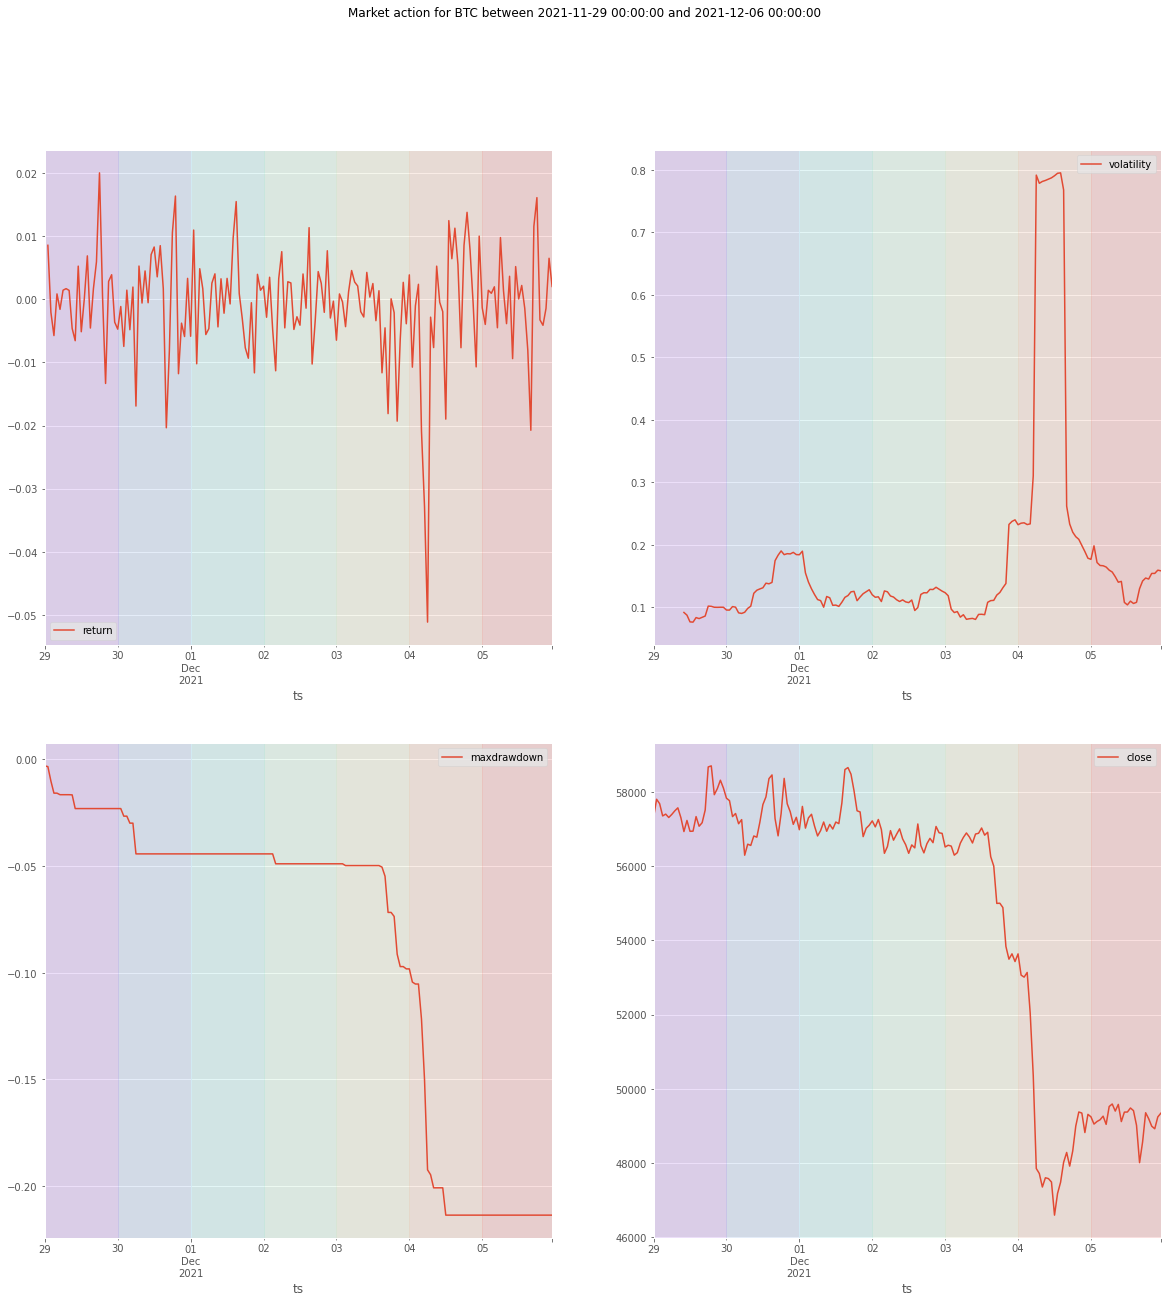

In [10]:
series_plot(prices[['return']], ax=ax[0, 0])
series_plot(prices[['volatility']], ax=ax[0, 1])
series_plot(prices[['maxdrawdown']], ax=ax[1, 0])
series_plot(prices[['close']], ax=ax[1, 1])
fig.suptitle(f'Market action for {token} between {from_date} and {to_date}')
fig

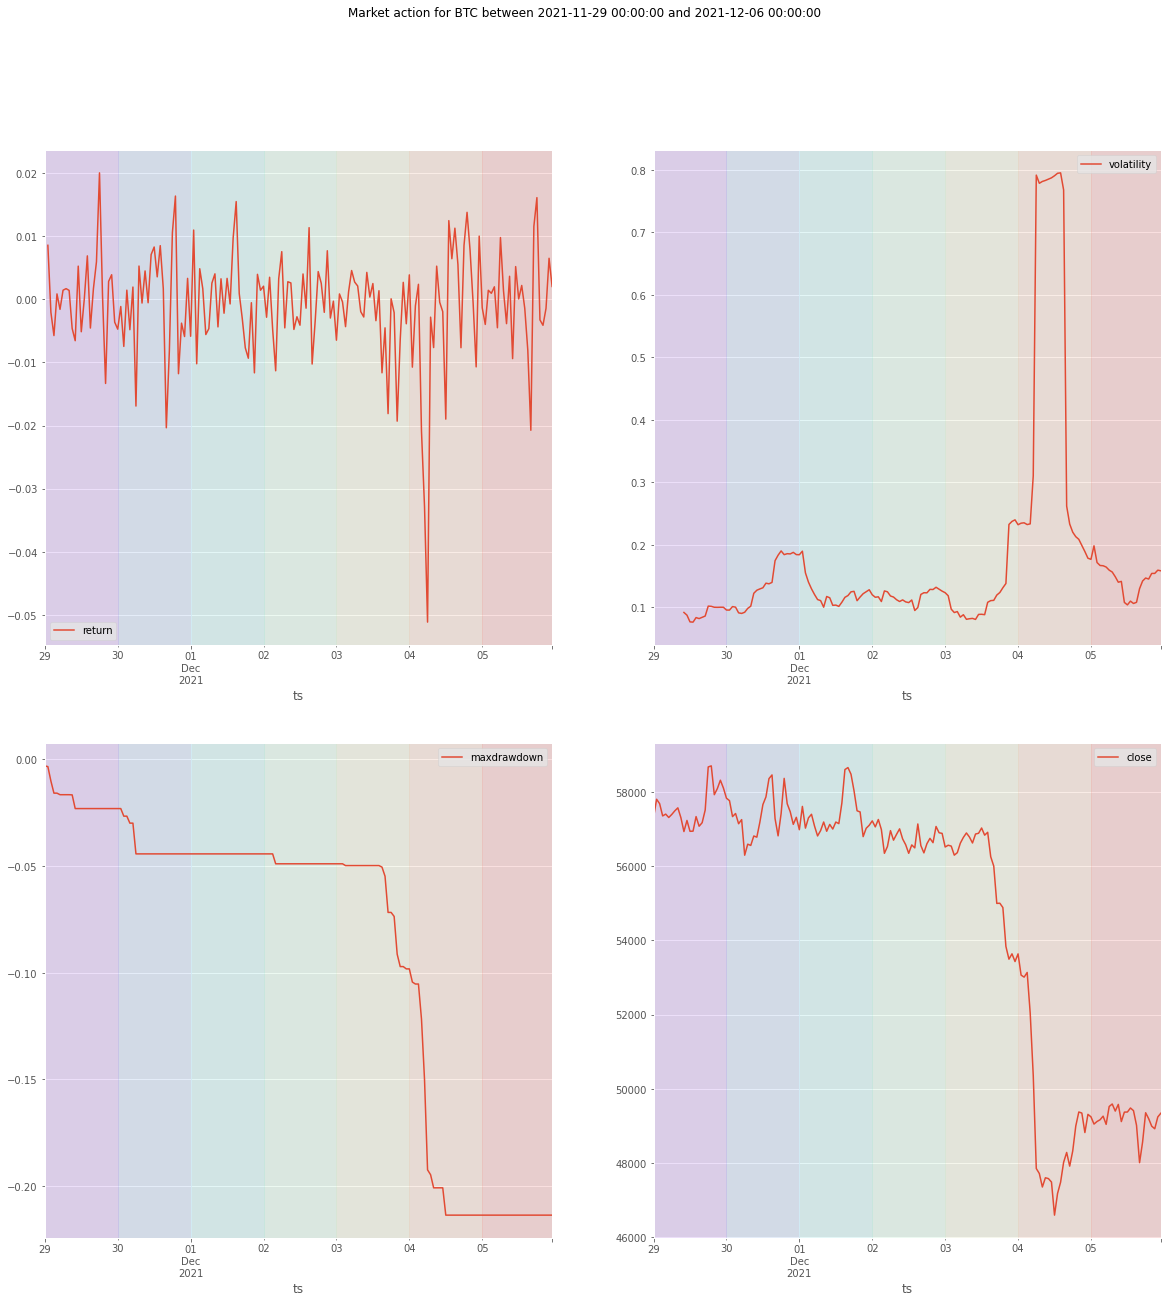

In [11]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)